import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sys
import matplotlib.pyplot as plt

In [3]:
#Load all data
table_scans = pd.read_csv("data/table_scans.csv")
table_meta_data = pd.read_csv("data/table_meta_data.csv")
segment_meta_data = pd.read_csv("data/segment_meta_data.csv")
attribute_meta_data = pd.read_csv("data/attribute_meta_data.csv")

In [4]:
table_scans = table_scans.merge(table_meta_data, on="TABLE_NAME", how="left")
table_scans = table_scans.merge(attribute_meta_data, on="COLUMN_NAME", how="left")
table_scans = table_scans.merge(segment_meta_data, on="COLUMN_NAME", how="left")

In [5]:
table_scans = table_scans[['SCAN_TYPE', 'TABLE_NAME', 'COLUMN_NAME', 'INPUT_ROWS',
       'OUTPUT_ROWS', 'RUNTIME_NS', 'ROW_COUNT_x',
       'MAX_CHUNK_SIZE', 'DATA_TYPE',
       'DISTINCT_VALUE_COUNT', 'IS_NULLABLE',
       'ENCODING', 'COMPRESSION', 'SIZE_IN_BYTES']]
table_scans = table_scans.rename(columns={"TABLE_NAME_x": "TABLE_NAME", "ROW_COUNT_x": "ROW_COUNT"})

In [6]:
table_scans.head()

,SCAN_TYPE,TABLE_NAME,COLUMN_NAME,INPUT_ROWS,OUTPUT_ROWS,RUNTIME_NS,ROW_COUNT,MAX_CHUNK_SIZE,DATA_TYPE,DISTINCT_VALUE_COUNT,IS_NULLABLE,ENCODING,COMPRESSION,SIZE_IN_BYTES
0,COLUMN_SCAN,customer,c_acctbal,150000,68274,18720022,150000,100000,float,140187,False,Dictionary,FixedSize4ByteAligned,782068
1,COLUMN_SCAN,customer,c_acctbal,150000,68274,18720022,150000,100000,float,140187,False,Dictionary,FixedSize2ByteAligned,295668
2,REFERENCE_SCAN,customer,c_phone,68274,18927,9302836,150000,100000,string,150000,False,Dictionary,FixedSize4ByteAligned,3600064
3,REFERENCE_SCAN,customer,c_phone,68274,18927,9302836,150000,100000,string,150000,False,Dictionary,FixedSize2ByteAligned,1700064
4,COLUMN_SCAN,customer,c_acctbal,150000,68269,19204111,150000,100000,float,140187,False,Dictionary,FixedSize4ByteAligned,782068


In [7]:
ohe_data = table_scans.drop(labels=['TABLE_NAME', 'COLUMN_NAME'], axis=1)
ohe_data['SELECTIVITY'] = (ohe_data['OUTPUT_ROWS'])/(ohe_data['INPUT_ROWS'])
ohe_data = pd.get_dummies(ohe_data, columns=['SCAN_TYPE', 'DATA_TYPE', 'IS_NULLABLE',
       'ENCODING', 'COMPRESSION'])
ohe_data.head()

,INPUT_ROWS,OUTPUT_ROWS,RUNTIME_NS,ROW_COUNT,MAX_CHUNK_SIZE,DISTINCT_VALUE_COUNT,SIZE_IN_BYTES,SELECTIVITY,SCAN_TYPE_COLUMN_SCAN,SCAN_TYPE_REFERENCE_SCAN,DATA_TYPE_float,DATA_TYPE_int,DATA_TYPE_string,IS_NULLABLE_False,ENCODING_Dictionary,COMPRESSION_FixedSize1ByteAligned,COMPRESSION_FixedSize2ByteAligned,COMPRESSION_FixedSize4ByteAligned
0,150000,68274,18720022,150000,100000,140187,782068,0.455160,1,0,1,0,0,1,1,0,0,1
1,150000,68274,18720022,150000,100000,140187,295668,0.455160,1,0,1,0,0,1,1,0,1,0
2,68274,18927,9302836,150000,100000,150000,3600064,0.277221,0,1,0,0,1,1,1,0,0,1
3,68274,18927,9302836,150000,100000,150000,1700064,0.277221,0,1,0,0,1,1,1,0,1,0
4,150000,68269,19204111,150000,100000,140187,782068,0.455127,1,0,1,0,0,1,1,0,0,1


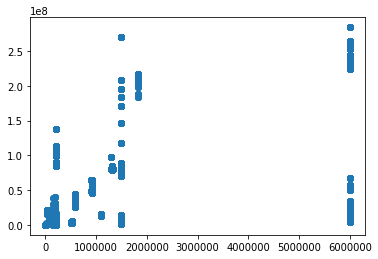

In [8]:
plt.scatter(table_scans['INPUT_ROWS'],table_scans['RUNTIME_NS'])

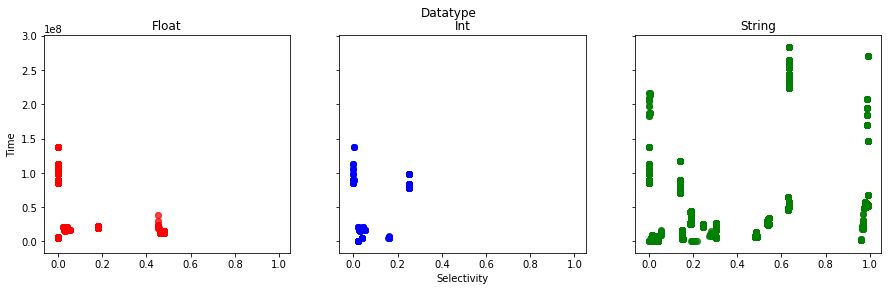

In [13]:
# looking at impact of the datatype

floats = ohe_data.loc[ohe_data['DATA_TYPE_float'] == 1]
ints = ohe_data.loc[ohe_data['DATA_TYPE_int'] == 1]
strings = ohe_data.loc[ohe_data['DATA_TYPE_string'] == 1]

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4))
fig.suptitle('Datatype')
axs[0].scatter(floats['SELECTIVITY'], floats['RUNTIME_NS'], color='r', alpha=0.5)
axs[0].set_title('Float')
axs[1].scatter(ints['SELECTIVITY'], ints['RUNTIME_NS'], color='b', alpha=0.5)
axs[1].set_title('Int')
axs[2].scatter(strings['SELECTIVITY'], strings['RUNTIME_NS'], color='g', alpha=0.5)
axs[2].set_title('String')

# for labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Selectivity")
plt.ylabel("Time")
plt.show()

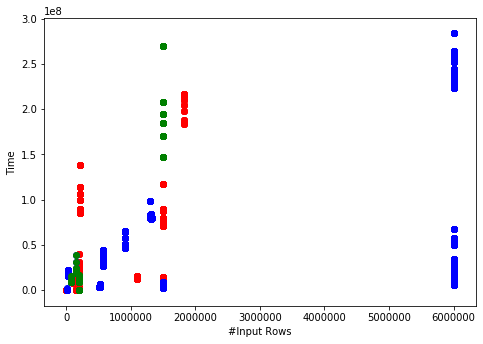

In [19]:
# looking at impact of the compression

c1 = ohe_data.loc[ohe_data['COMPRESSION_FixedSize1ByteAligned'] == 1]
c2 = ohe_data.loc[ohe_data['COMPRESSION_FixedSize2ByteAligned'] == 1]
c3 = ohe_data.loc[ohe_data['COMPRESSION_FixedSize4ByteAligned'] == 1]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(c1['INPUT_ROWS'], c1['RUNTIME_NS'], color='r')
ax.scatter(c2['INPUT_ROWS'], c2['RUNTIME_NS'], color='b')
ax.scatter(c3['INPUT_ROWS'], c3['RUNTIME_NS'], color='g')
ax.set_xlabel('#Input Rows')
ax.set_ylabel('Time')
plt.show()